## Setup

In [1]:
import outlaw.nb_util as util
util.setup_nb()

In [2]:
import outlaw.berry as berry
import outlaw.quad as quad
import outlaw.inla as inla
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Run Outlaw hyperparameter posterior

In [4]:
dtype = np.float64
# data = berry.figure1_data(N=1)[0].astype(dtype)
data = berry.figure2_data(N=1)[0].astype(dtype)
# sig2_rule = quad.log_gauss_rule(70, 1e-6, 1e3)
sig2_rule = quad.log_gauss_rule(70, 1e-3, 1e3)
sig2 = sig2_rule.pts
# sig2_df = pd.DataFrame(dict(theta=sig2_rule.pts, wts=sig2_rule.wts))
# sig2_df.to_csv('sig2_rule.csv', index=False)

In [5]:
inla_ops = berry.optimized(sig2, dtype=dtype).config(
    max_iter=20, opt_tol=dtype(1e-9)
)

# compute hyperparameter posterior
logpost, x_max, hess_info, iters = jax.jit(
    inla_ops.laplace_logpost
)(np.zeros((sig2.shape[0], 4), dtype=dtype), dict(sig2=sig2), data)
post = inla.exp_and_normalize(logpost, sig2_rule.wts.astype(dtype), axis=0)

In [121]:
# compute latent posteriors
arm_logpost_f = jax.jit(
    jax.vmap(
        inla_ops.cond_laplace_logpost,
        in_axes=(None, None, None, None, 0, None, None),
    ),
    static_argnums=(5, 6),
)
invv = jax.jit(jax.vmap(inla_ops.invert))

inv_hess = invv(hess_info)
arm_idx = 0
cx, wts = inla.gauss_hermite_grid(
    x_max, inv_hess[..., arm_idx, :], arm_idx, n=25
)
cx = cx[:,0]
wts = wts[:,0]

arm_logpost = arm_logpost_f(
    x_max, inv_hess[:, :, arm_idx], dict(sig2=sig2, theta=None), data, cx, arm_idx, True
)
arm_post = inla.exp_and_normalize(arm_logpost, wts, axis=0)

In [122]:
arm_post.shape

(25, 70)

In [123]:
arm_quad = quad.simpson_rule(301, -15, 2)

In [124]:
interp_vmap = jax.vmap(lambda *args: jnp.interp(*args, 0, 0), in_axes=(None, 1, 1))
interp_marg_condsig2 = interp_vmap(arm_quad.pts, cx, arm_post).T

In [125]:
include = cx[None] < arm_quad.pts[:, None, None]
zero = ~np.any(include, axis=1)

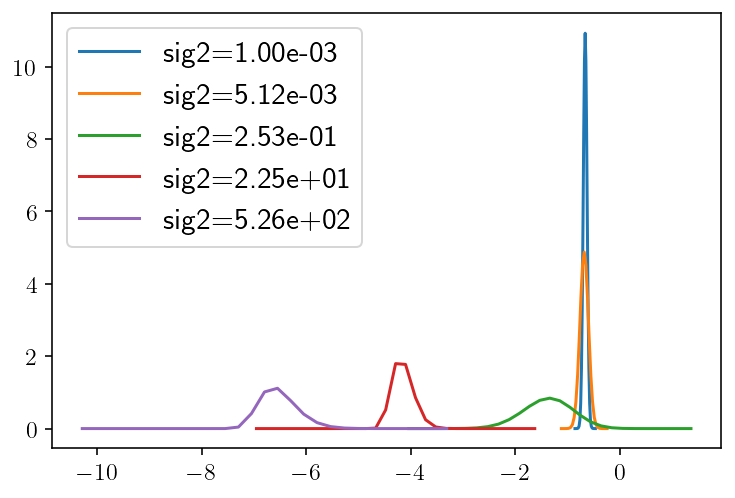

In [138]:
for i in range(0, sig2_rule.pts.shape[0], 15):
    plt.plot(cx[:, i], arm_post[:, i], label='sig2={:.2e}'.format(sig2_rule.pts[i]))
plt.legend()
plt.show()

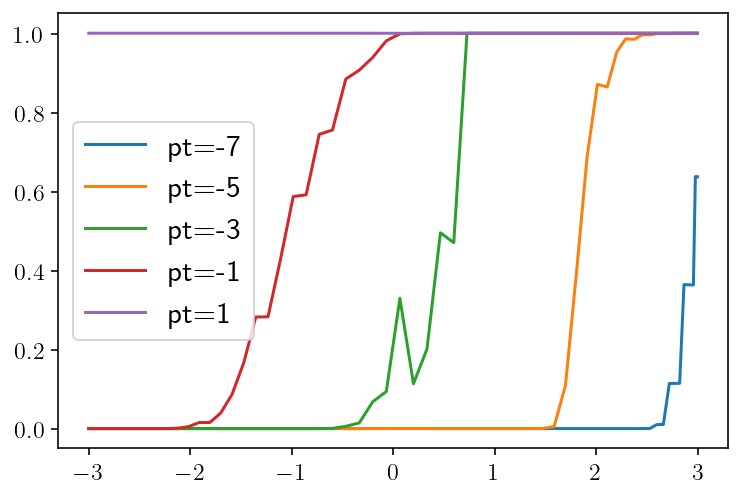

In [140]:
for pt in [-7, -5, -3, -1, 1]:
    include = cx < pt
    x_integral = jnp.trapz(arm_post * include, x=cx, axis=0)
    plt.plot(np.log10(sig2_rule.pts), x_integral, label='pt={}'.format(pt))
plt.legend()
plt.show()

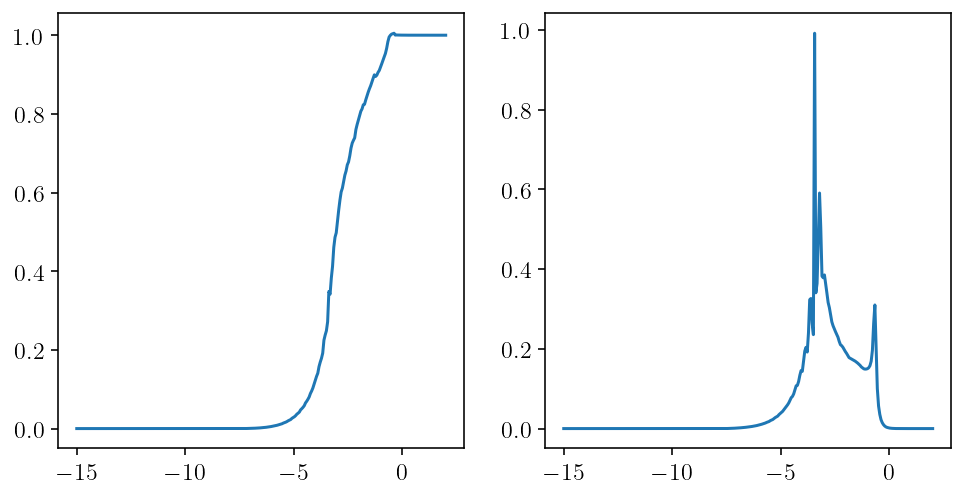

In [129]:
interp_vmap = jax.vmap(lambda *args: jnp.interp(*args, 0, 0), in_axes=(None, 1, 1))


def unconditional(pt):
    include = cx < pt
    x_integral = jnp.trapz(arm_post * include, x=cx, axis=0)

    first_above = jnp.argmin(include, axis=0)
    y_last_below = arm_post[first_above - 1, np.arange(sig2_rule.pts.shape[0])]
    x_last_below = cx[first_above - 1, np.arange(sig2_rule.pts.shape[0])]
    interp = interp_vmap(pt, cx, arm_post).T
    x_integral += jnp.trapz(
        jnp.array([y_last_below, interp]),
        jnp.array([x_last_below, jnp.full_like(x_last_below, pt)]),
        axis=0,
    )

    return jnp.where(
        jnp.any(include), jnp.sum(x_integral * post * sig2_rule.wts, axis=0), 0
    )


uncon_cdf = jax.vmap(unconditional)(arm_quad.pts)
uncon_pdf = jax.vmap(jax.grad(unconditional))(arm_quad.pts)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(arm_quad.pts, uncon_cdf)
plt.subplot(1, 2, 2)
plt.plot(arm_quad.pts, uncon_pdf)
plt.show()


In [30]:
arm_post.shape, include.shape

((25, 40), (51, 25, 40))

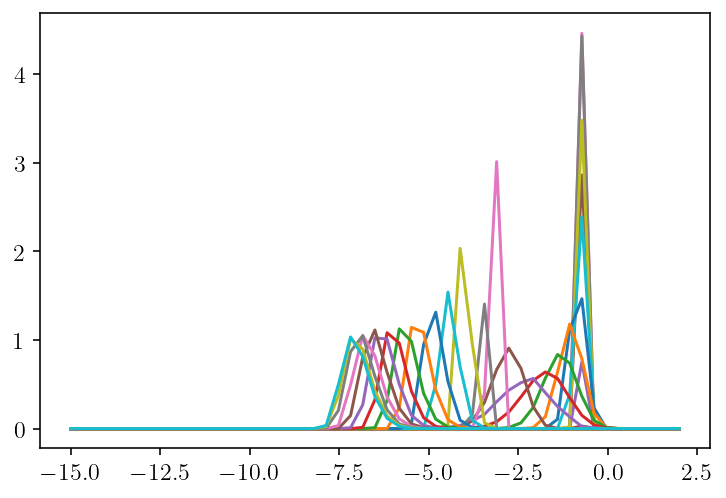

In [19]:
plt.plot(arm_quad.pts, interp_marg_condsig2)
plt.show()

In [ ]:
arm_quad

In [ ]:
for sig_idx in np.linspace(0, sig2.shape[0] - 1, 5).astype(int):
    plt.plot(cx[:,sig_idx], arm_post[:,sig_idx])
    plt.show()

In [ ]:
arm_idx = 0
inv_hess = jax.vmap(inla_ops.invert)(hess_info)

arm_quad = quad.simpson_rule(1001, -15, 2)
cx = np.tile(arm_quad.pts[:, None], (1, sig2.shape[0]))
wts = np.tile(arm_quad.wts[:, None], (1, sig2.shape[0]))
cond_laplace_f = jax.vmap(
    lambda *args: inla_ops.cond_laplace_logpost(*args, reduced=True),
    in_axes=(None, None, None, None, 0, None),
)
logpost_arm = cond_laplace_f(
    x_max, inv_hess[:, :, arm_idx], dict(sig2=sig2), data, cx, arm_idx
)
arm_marg_condsig2 = inla.exp_and_normalize(logpost_arm, wts, axis=0)
for sig_idx in np.linspace(0, sig2.shape[0] - 1, 5).astype(int):
    plt.plot(cx[:,sig_idx], arm_marg_condsig2[:,sig_idx])
    plt.show()

In [85]:
# cond_mu = inla.mvn_conditional_meanv(x_max, inv_hess[:, :, arm_idx], cx[0], arm_idx)
# cond_hess = inla_ops.reduced_hessv(cond_mu, dict(sig2=sig2), data, arm_idx)

In [119]:
# hess_a
# full_hess = jax.vmap(lambda x: jnp.diag(x[0]) + jnp.full((4, 4), x[1]))(hess_info)
# np.linalg.svd(full_hess[67])
# np.linalg.inv(full_hess[67])
# np.sqrt(-np.diag(inv_hess[67]))
# # index 67 is really messed up!! i think it has to do with bad hessian
# # behavior. or maybe a failure in the solver?
# hess_a, hess_b = jax.tree_util.tree_map(lambda x: x[67], hess_info)
# hess_ex = np.diag(hess_a) + np.full((4,4), hess_b)
# np.testing.assert_allclose(np.linalg.inv(hess_ex), inv_hess[67])
# np.linalg.svd(inv_hess[np.array([10, 30, 50, 67, 80])])[1]
# inv_hess[67,0, :] / inv_hess[67][0,0]
# inla_ops.logdetv(cond_hess)
# np.where(np.isnan(logpost_arm[0]))[0]
# np.sum(arm_marg_condsig2 * arm_quad.wts[:, None], axis=0)
# arm_marg_condsig2[2]

DeviceArray([-0.42338719, -1.16904384, -6.74541474, -7.2033303 ], dtype=float64)

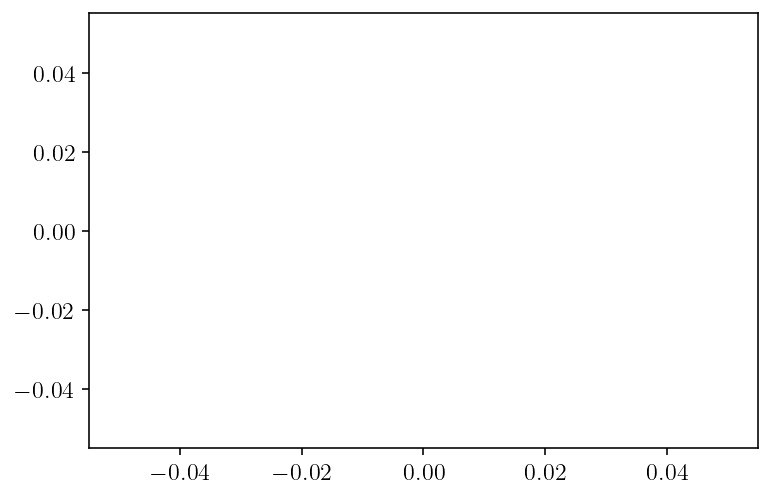

In [51]:

arm_marg = np.sum(arm_marg_condsig2 * post * sig2_rule.wts, axis=-1)
plt.plot(cx[:, 0], arm_marg)
plt.show()

In [11]:

# cx, wts = inla.gauss_hermite_grid(x_max, inv_hess[None, :, arm_idx], arm_idx, n=25)
# cx = cx[:,0]
# wts = wts[:,0]
# cond_laplace_f = jax.vmap(
#     lambda *args: inla_ops.cond_laplace_logpost(*args, reduced=True),
#     in_axes=(None, None, None, None, 0, None),
# )
# logpost_arm = cond_laplace_f(
#     x_max, inv_hess[:, :, arm_idx], dict(sig2=sig2), data, cx, arm_idx
# )
# arm_marg_condsig2 = inla.exp_and_normalize(logpost_arm, wts, axis=0)

/tmp/ipykernel_650/3612733563.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(sig2), np.log10(arm_marg_condsig2.T))


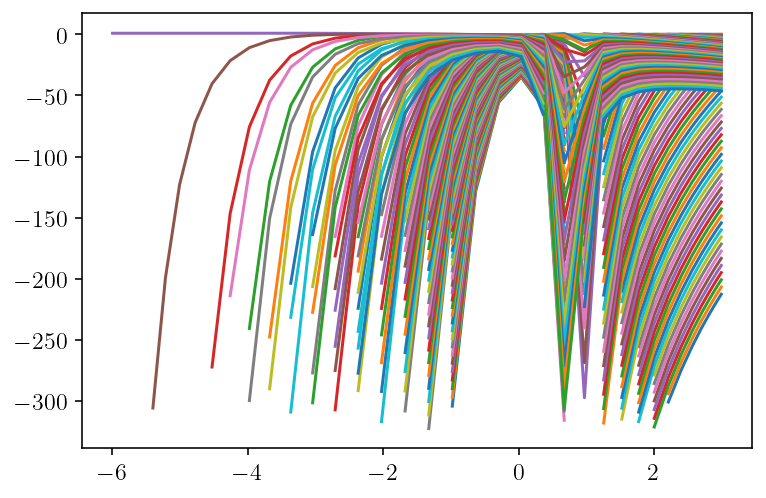

In [12]:
plt.plot(np.log10(sig2), np.log10(arm_marg_condsig2.T))
plt.show()

In [13]:
# interp_quad = quad.simpson_rule(37, -10, 1)
# interp_grid = interp_quad.pts
# interp_vmap = jax.vmap(lambda *args: jnp.interp(*args, -1e9, -1e9), in_axes=(None, 1, 1))
# interp_marg_condsig2 = interp_vmap(interp_grid, cx, logpost_arm).T
# plt.plot(interp_grid, interp_marg_condsig2)
# plt.ylim([-600, 0])
# plt.show()
# interp_marg = np.sum(interp_marg_condsig2 * sig2_rule.wts, axis=-1)
# plt.plot(interp_grid, interp_marg)
# plt.show()

## Compare conditional modes

In [14]:
import jax.numpy as jnp
def get_mode(sigv):
    sig2 = jnp.array([sigv])
    inla_ops = berry.optimized(sig2, dtype=dtype).config(
        max_iter=20, opt_tol=dtype(1e-9)
    )
    logpost, x_max, hess, iters = jax.jit(
        inla_ops.laplace_logpost
    )(np.zeros((sig2.shape[0], 4), dtype=dtype), dict(sig2=sig2), data)
    return logpost, x_max + berry.logit_p1, x_max, hess

In [16]:
get_mode(2.450777)

(DeviceArray([-61.3552454], dtype=float64),
 DeviceArray([[-3.50623784, -2.70361474, -1.12019645, -0.97990449]], dtype=float64),
 DeviceArray([[-2.65893998, -1.85631688, -0.27289859, -0.13260663]], dtype=float64),
 (DeviceArray([[-0.97376189, -1.58446442, -6.89952661, -7.35310017]], dtype=float64),
  DeviceArray([0.8034093], dtype=float64)))

## Compare hyperparameter posteriors

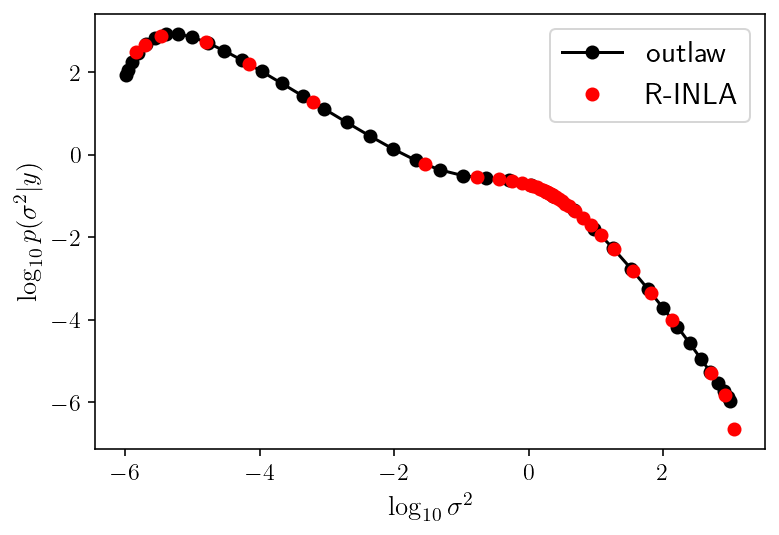

In [17]:
rinla_df = pd.read_csv('hyperpar_data2.csv')
# rinla_sig2 = 1.0 / rinla_df['x'].to_numpy()
# rinla_post = (rinla_df['y'] / rinla_sig2 ** 2).to_numpy()
rinla_sig2 = 1.0 / np.exp(rinla_df['x']).to_numpy()
rinla_post = (rinla_df['y'] / rinla_sig2 ** 1).to_numpy()

plt.plot(np.log10(sig2), np.log10(post), 'k-o', label='outlaw')
plt.plot(np.log10(rinla_sig2), np.log10(rinla_post), 'ro', label='R-INLA')
plt.xlabel("$\log_{10} \sigma^2$")
plt.ylabel("$\log_{10} p(\sigma^2 | y)$")
plt.legend()
plt.show()

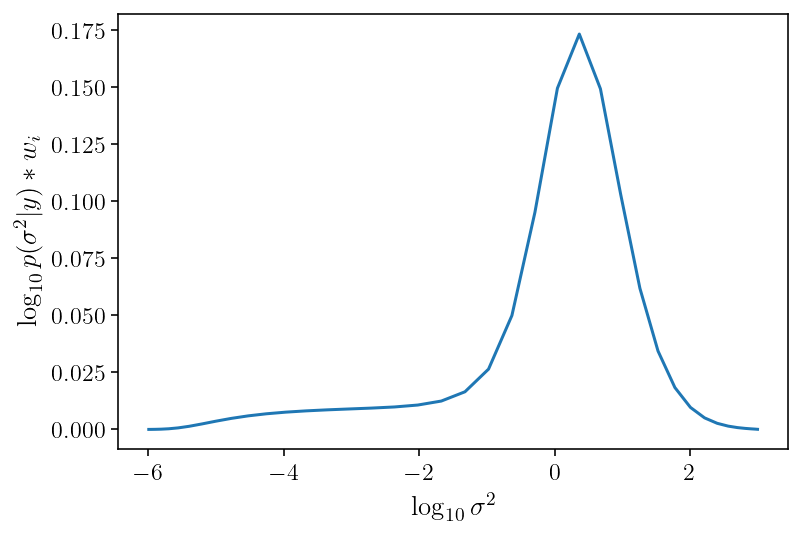

In [18]:
plt.plot(np.log10(sig2), post * sig2_rule.wts)
plt.xlabel("$\log_{10} \sigma^2$")
plt.ylabel("$\log_{10} p(\sigma^2 | y) * w_i$")
plt.show()

## Multi-compare hyperparameters

skipping 1e-06


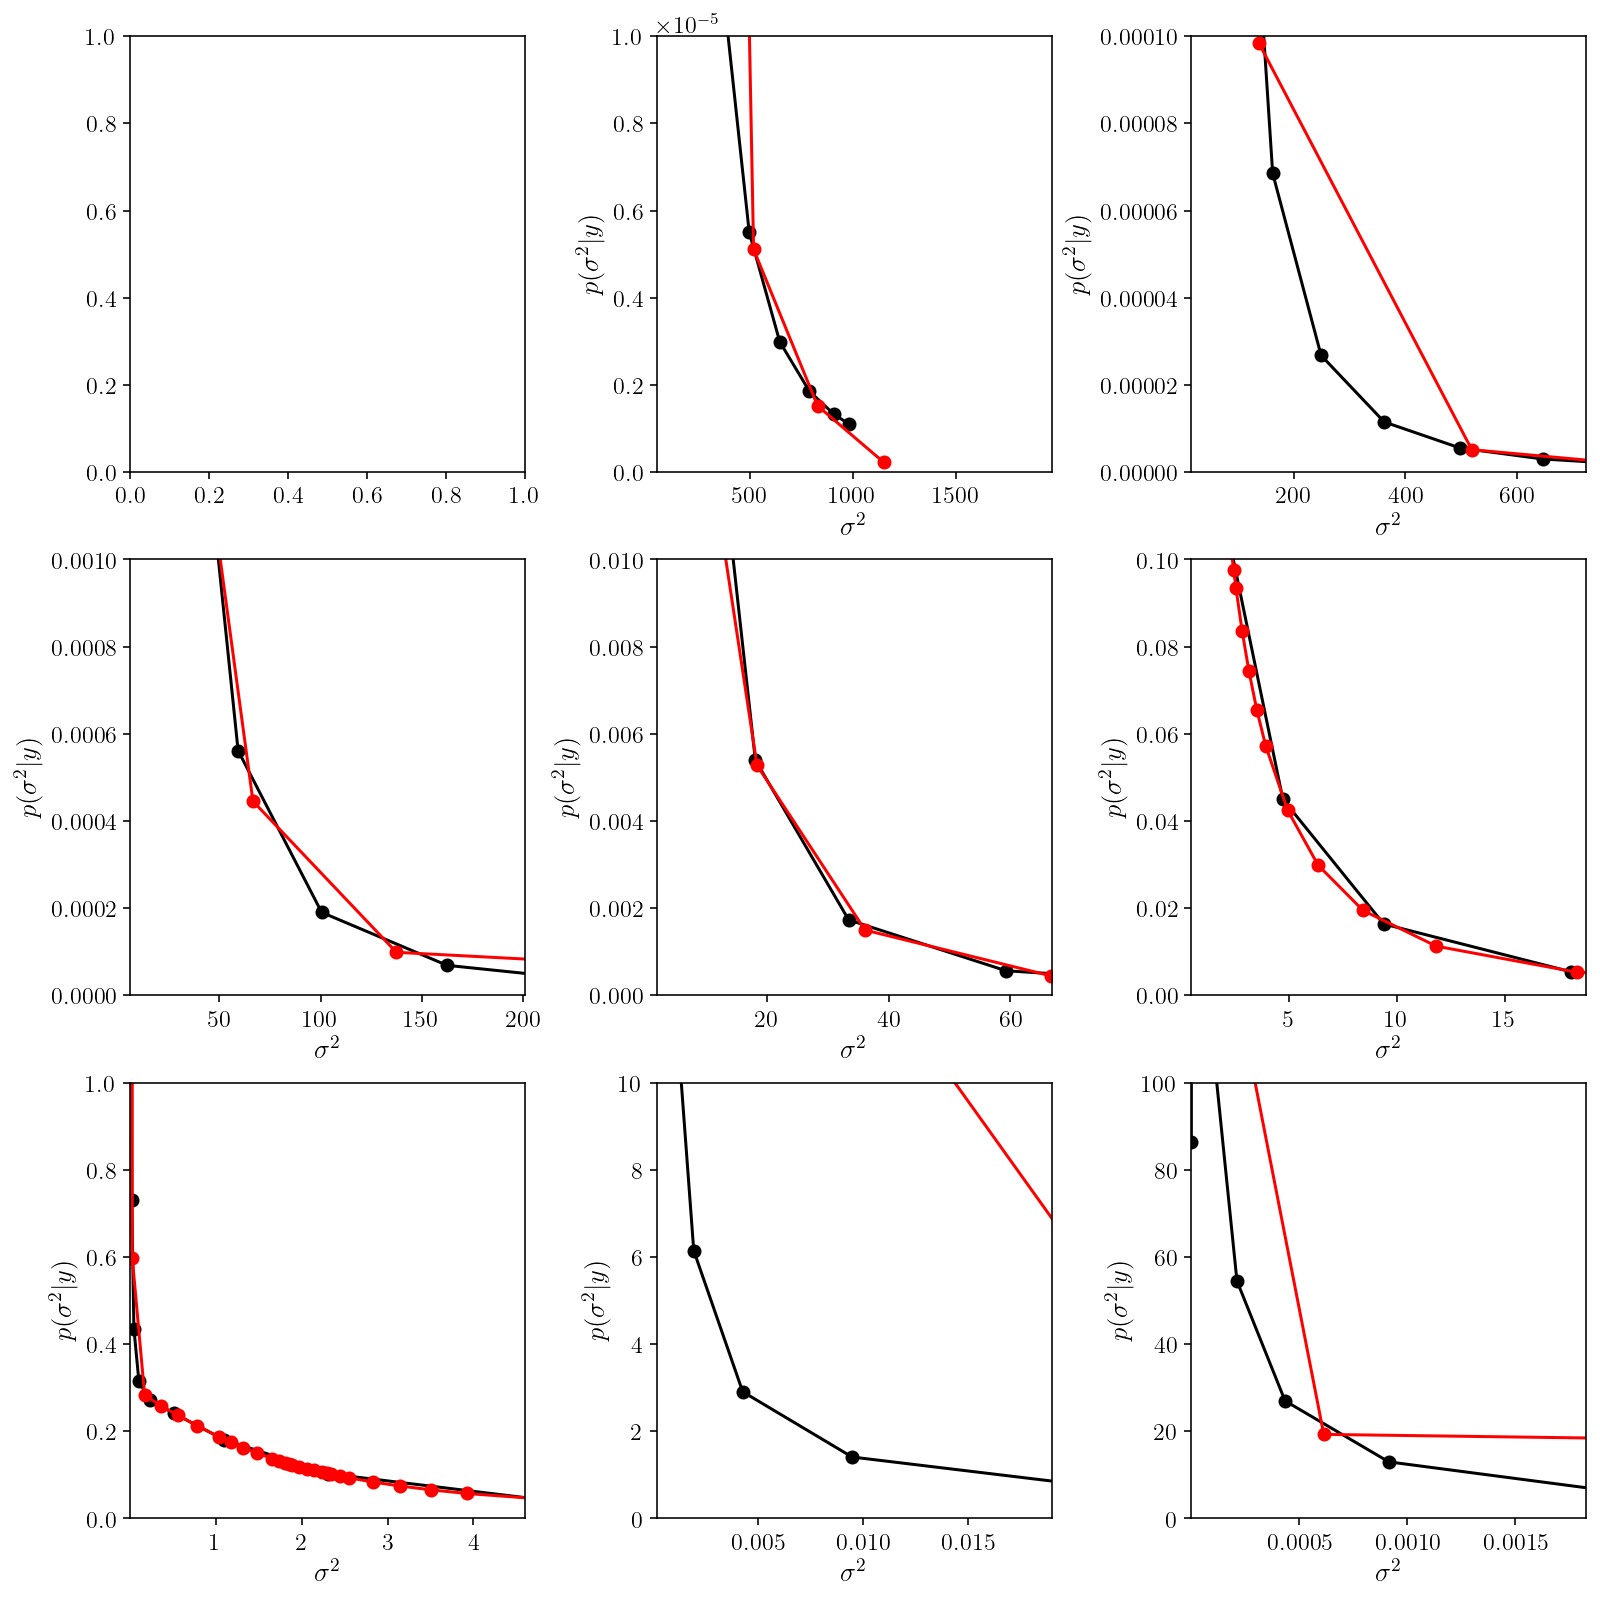

In [19]:
plt.figure(figsize=(11,11), constrained_layout=True)
for i, upper in enumerate(10.0 ** np.arange(-6, 3)):
    plt.subplot(3, 3, i + 1)
    relevant_pts = (post < upper) & (post > upper * 0.1)
    if relevant_pts.sum() == 0:
        print('skipping', upper)
        continue
    xlim = [0.1 * np.min(sig2[relevant_pts]), np.max(sig2[relevant_pts]) * 2]
    plt.plot(sig2, post, 'k-o', label='outlaw')
    plt.plot(rinla_sig2, rinla_post, 'r-o', label='R-INLA')
    plt.xlabel("$\sigma^2$")
    plt.ylabel("$p(\sigma^2 | y)$")
    plt.xlim(xlim)
    plt.ylim([0, upper])
    if i == 0:
        plt.legend()
plt.show()

## Compare latent marginals

In [20]:
rinla_latent = pd.read_csv('latent_data.csv')

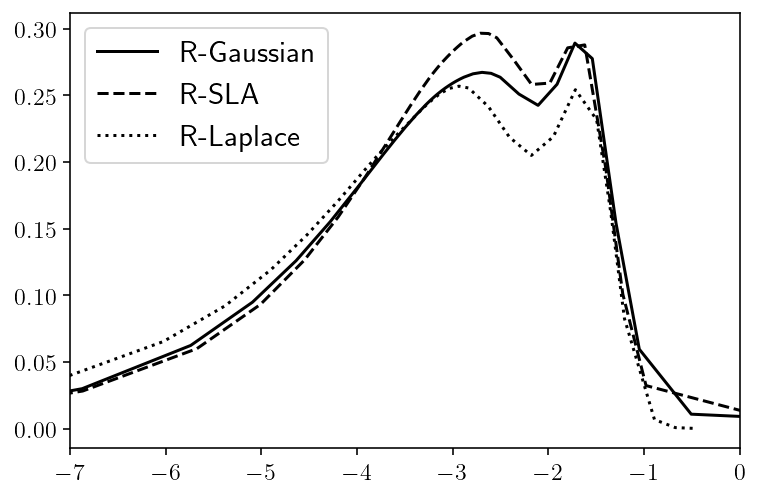

In [21]:
for i, strategy in enumerate(rinla_latent["strategy"].unique()):
    strat_name = {
        "gaussian": "Gaussian",
        "laplace": "Laplace",
        "simplified.laplace": "SLA",
    }[strategy]
    subset_df = rinla_latent.loc[rinla_latent["strategy"] == strategy]
    plt.plot(
        subset_df["x"] + berry.mu_0 + berry.logit_p1,
        subset_df["y"],
        color='k',
        linestyle=['solid', 'dashed', 'dotted'][i],
        label="R-" + strat_name,
    )
plt.xlim([-7, 0])
plt.legend()
plt.show()


## extra

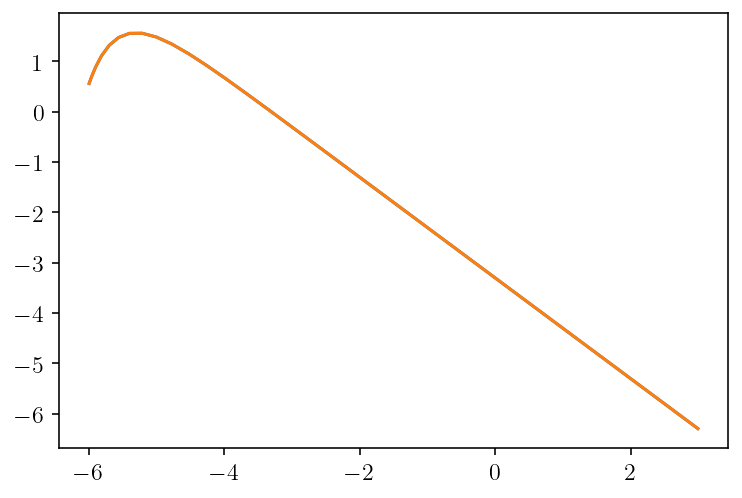

In [21]:
sig2 = sig2_rule.pts
sig2_alpha = 0.0005
sig2_beta = 0.000005
invg_pdf = scipy.stats.invgamma.pdf(sig2, sig2_alpha, scale=sig2_beta)
g_pdf = scipy.stats.gamma.pdf(sig2, sig2_alpha, scale=(1.0 / sig2_beta)*(sig2 ** 2))
plt.plot(np.log10(sig2), np.log10(invg_pdf))
plt.plot(np.log10(sig2), np.log10(g_pdf))
plt.show()

In [24]:
scipy.stats.gamma.pdf(1.0, 1.0, scale=2.0)

0.3032653298563167

In [25]:
scipy.stats.gamma.pdf(0.5, 1.0, scale=1.0) / 2

0.3032653298563167

In [33]:
scipy.stats.gamma.logpdf(1.0 / sig2, sig2_alpha, scale=sig2_beta)# / sig2 ** 2

array([-1.96381100e+11, -1.81676214e+11, -1.58015529e+11, -1.29317018e+11, -9.96982724e+10,
       -7.25228107e+10, -4.98709637e+10, -3.24926427e+10, -2.01096924e+10, -1.18566540e+10,
       -6.68090164e+09, -3.61012718e+09, -1.87772532e+09, -9.43780741e+08, -4.60295183e+08,
       -2.18777892e+08, -1.01792291e+08, -4.65767553e+07, -2.10575852e+07, -9.45162322e+06,
       -4.23209306e+06, -1.89956399e+06, -8.58806770e+05, -3.92965390e+05, -1.82841347e+05,
       -8.69075216e+04, -4.23887699e+04, -2.13077266e+04, -1.10846449e+04, -5.99130342e+03,
       -3.37714731e+03, -1.99207677e+03, -1.23355452e+03, -8.04148317e+02, -5.53254722e+02,
       -4.02596593e+02, -3.10443412e+02, -2.54065392e+02, -2.20958169e+02, -2.04394049e+02])

In [ ]:
def joint_at_max(x):
    return inla_ops.log_jointv(x_max + x, None, data)[-1]
import numdifftools
for step in [0.01, 0.1, 1.0]:
    H = numdifftools.Hessian(joint_at_max, step)(np.zeros(4, dtype=dtype))
    print(step, np.linalg.slogdet(H)[1])

0.01 -1.0999984915225336
0.1 -1.0960460181310459
1.0 -0.7511898094989797
